In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import torch 
import torchvision

import matplotlib.pyplot as plt
import torch.nn as nn

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid

import numpy as np
import os

%matplotlib inline

In [5]:
gpu_is_available = torch.cuda.is_available()

if gpu_is_available:
    print("gpu is available")
else:
    print('gpu not available')
    

gpu is available


In [6]:
data_dir = '/kaggle/input/flowers-recognition/flowers/flowers/'

# classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
dataset = datasets.ImageFolder(data_dir,transform=transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor()]))



torch.Size([3, 224, 224])
0
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
769
1055
784
734
984
4323


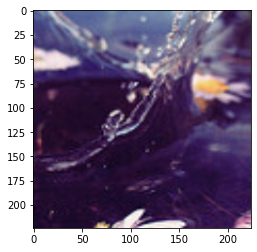

In [7]:
img,label = dataset[2]

print(img.shape)

plt.imshow(img.permute(1,2,0))

print(label)

print(dataset.classes)

print (len(os.listdir(data_dir+'daisy')))
print (len(os.listdir(data_dir+'dandelion')))
print (len(os.listdir(data_dir+'rose')))
print (len(os.listdir(data_dir+'sunflower')))
print (len(os.listdir(data_dir+'tulip')))

print(len(dataset))

#4326 images in total


In [8]:
#splitting to train and test 

test_size = 300
val_size  = 300

random_seed = 69
torch.manual_seed(random_seed)

train_size = len(dataset) - test_size - val_size

train_ds,val_ds,test_ds = random_split(dataset,[train_size,val_size,test_size])

print (len(train_ds),len(val_ds),len(test_ds))




3723 300 300


In [9]:
batch_size = 20

train_dl = DataLoader(train_ds,batch_size = batch_size,num_workers=4,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=batch_size,num_workers=4)
test_dl = DataLoader(test_ds,batch_size = batch_size,num_workers=4,shuffle=True)




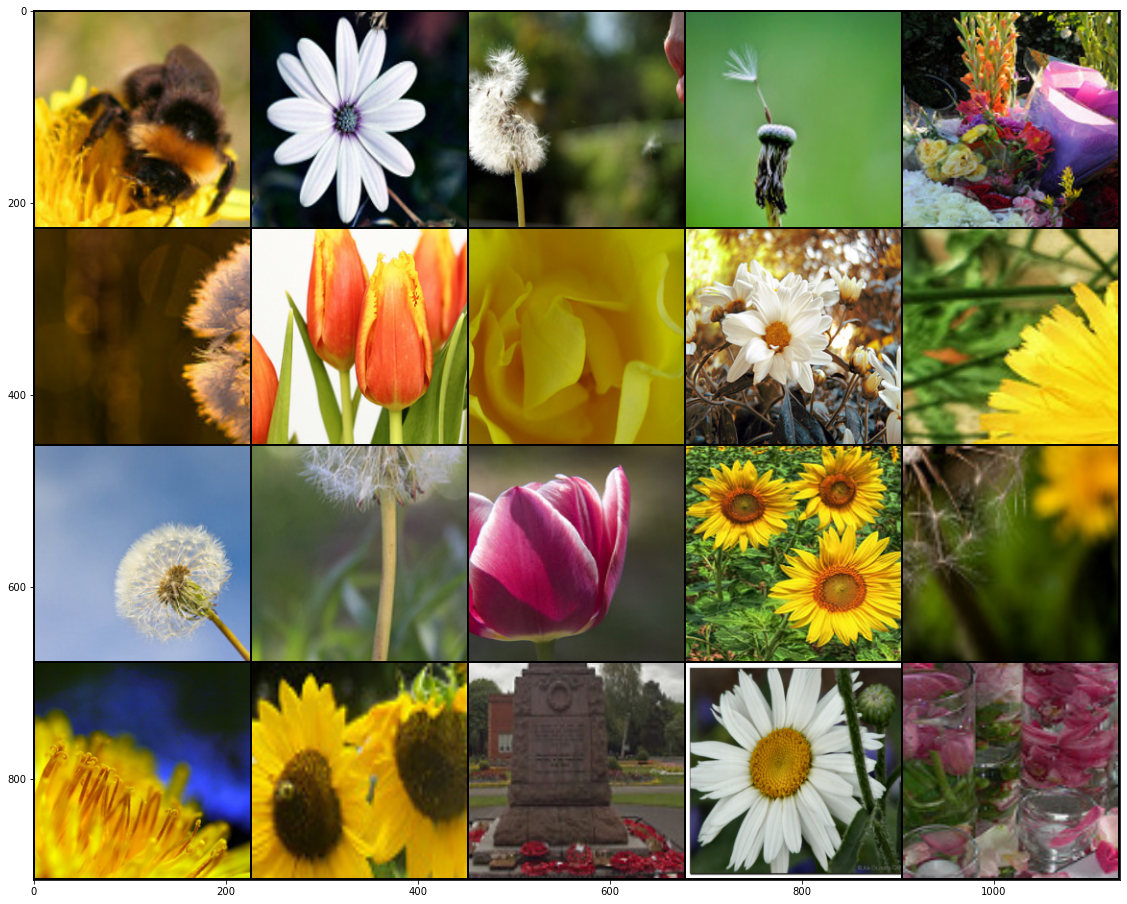

In [10]:
# view a batch of images

for img,label in train_dl:
    plt.figure(figsize=(20,16))
    plt.imshow(make_grid(img,nrow=5).permute(1,2,0))
    break

In [11]:
#define the vgg16 model 

vgg16 = models.vgg16(pretrained=True)

#print the structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [12]:

print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features)

4096
1000


In [13]:
#freeze the parameters for the feature layers

for param in vgg16.features.parameters():
    param.requires_grad = False



In [14]:
#change the last layer of the classifier layer-group

num_inputs = vgg16.classifier[6].in_features

new_layer = nn.Linear(num_inputs,len(dataset.classes))

vgg16.classifier[6] = new_layer

if gpu_is_available:
    vgg16.cuda()

print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features)
                                
                    


4096
5


In [15]:
#define loss function and optimizer

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(vgg16.classifier.parameters(),lr=learning_rate)

In [16]:
#training loop


# num_epochs = 2

# for epoch in range(num_epochs):
    
#     train_losses = 0.0
    
#     for batch , (img,label) in enumerate(train_dl):
        
#         if gpu_is_available:
#             img=img.cuda()
#             label=label.cuda()
    
       
        
#         optimizer.zero_grad()
        
#         output = vgg16(img)
        
#         loss = criterion(output,label)
        
                           
#         loss.backward()
        
#         optimizer.step()
        
#         train_losses += loss.item()
        
#         if batch % 20 == 19:
#             print('epoch[%d] : batch %d Loss: %.6f' %(epoch,batch+1,train_losses/20))
#             train_losses = 0
        
    
    
        
        
        
        
        

In [17]:
#function to calculate accuracy

def accuracy(output,label):
    _,maxindx = torch.max(output,dim=1)
    return torch.tensor(torch.sum(maxindx==label).item()/len(maxindx))
    
def evaluate(val_dl):
    
    with torch.no_grad():
        val_losses = []
        val_accs = []
        for batch, (img,label) in enumerate(val_dl):
            vgg16.eval()
            if gpu_is_available:
                img=img.cuda()
                label=label.cuda()

            val_output = vgg16(img)

            v_loss = criterion(val_output,label)
            val_losses.append(v_loss.item())
            
            v_accuracy = accuracy(val_output,label)
            val_accs.append(v_accuracy.item())
        
        vl = sum(val_losses)/len(val_losses)
        va = sum(val_accs)/len(val_accs)
        
        return vl, va
           
    
    
def fit(num_epochs=2):
  
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_val_accuracy = []
    for epoch in range(num_epochs):

        train_losses = []

        for batch , (img,label) in enumerate(train_dl):
            
            vgg16.train()

            if gpu_is_available:
                img=img.cuda()
                label=label.cuda()

            optimizer.zero_grad()

            output = vgg16(img)

            loss = criterion(output,label)
            
            
            loss.backward()

            optimizer.step()

            train_losses.append(loss.item())

            if batch % 20 == 19:
                print('epoch[%d] : batch %d Loss: %.6f' %(epoch,batch+1,sum(train_losses)/len(train_losses)))
        
        
        epoch_train_losses.append(sum(train_losses)/len(train_losses))
        val_loss,val_acc = evaluate(val_dl)
        epoch_val_losses.append(val_loss)
        epoch_val_accuracy.append(val_acc)
        
        print('epoch[%d]: Training loss: %.8f  Val Loss: %.8f Val Acc: %.8f' %(epoch,
                                                                               epoch_train_losses[epoch], 
                                                                              epoch_val_losses[epoch],
                                                                              epoch_val_accuracy[epoch]))
        
    return epoch_train_losses, epoch_val_losses, epoch_val_accuracy
        
        

In [18]:
out_train_loss, out_val_loss, out_val_acc = fit(25)

epoch[0] : batch 20 Loss: 1.546597
epoch[0] : batch 40 Loss: 1.463271
epoch[0] : batch 60 Loss: 1.412279
epoch[0] : batch 80 Loss: 1.354773
epoch[0] : batch 100 Loss: 1.302073
epoch[0] : batch 120 Loss: 1.255133
epoch[0] : batch 140 Loss: 1.218502
epoch[0] : batch 160 Loss: 1.187575
epoch[0] : batch 180 Loss: 1.157136
epoch[0]: Training loss: 1.14896822  Val Loss: 0.84372273 Val Acc: 0.76666666
epoch[1] : batch 20 Loss: 0.877319
epoch[1] : batch 40 Loss: 0.866869
epoch[1] : batch 60 Loss: 0.860668
epoch[1] : batch 80 Loss: 0.857471
epoch[1] : batch 100 Loss: 0.848961
epoch[1] : batch 120 Loss: 0.841896
epoch[1] : batch 140 Loss: 0.830102
epoch[1] : batch 160 Loss: 0.821875
epoch[1] : batch 180 Loss: 0.817529
epoch[1]: Training loss: 0.81156868  Val Loss: 0.70518624 Val Acc: 0.77666668
epoch[2] : batch 20 Loss: 0.767258
epoch[2] : batch 40 Loss: 0.772942
epoch[2] : batch 60 Loss: 0.749358
epoch[2] : batch 80 Loss: 0.723485
epoch[2] : batch 100 Loss: 0.711110
epoch[2] : batch 120 Loss: 0

epoch[20] : batch 100 Loss: 0.460737
epoch[20] : batch 120 Loss: 0.473338
epoch[20] : batch 140 Loss: 0.473619
epoch[20] : batch 160 Loss: 0.470762
epoch[20] : batch 180 Loss: 0.473061
epoch[20]: Training loss: 0.47039731  Val Loss: 0.46641411 Val Acc: 0.81666667
epoch[21] : batch 20 Loss: 0.458819
epoch[21] : batch 40 Loss: 0.469580
epoch[21] : batch 60 Loss: 0.470878
epoch[21] : batch 80 Loss: 0.457912
epoch[21] : batch 100 Loss: 0.448201
epoch[21] : batch 120 Loss: 0.449292
epoch[21] : batch 140 Loss: 0.448839
epoch[21] : batch 160 Loss: 0.451889
epoch[21] : batch 180 Loss: 0.455867
epoch[21]: Training loss: 0.46043062  Val Loss: 0.43485261 Val Acc: 0.84333334
epoch[22] : batch 20 Loss: 0.468498
epoch[22] : batch 40 Loss: 0.466172
epoch[22] : batch 60 Loss: 0.455038
epoch[22] : batch 80 Loss: 0.442509
epoch[22] : batch 100 Loss: 0.444883
epoch[22] : batch 120 Loss: 0.445742
epoch[22] : batch 140 Loss: 0.452553
epoch[22] : batch 160 Loss: 0.444551
epoch[22] : batch 180 Loss: 0.448454

In [19]:
#another 25 epochs
out_train_loss1, out_val_loss1, out_val_acc1 = fit(25)

out_train_loss += out_train_loss1
out_val_loss += out_val_loss1
out_val_acc += out_val_acc1


epoch[0] : batch 20 Loss: 0.401275
epoch[0] : batch 40 Loss: 0.408092
epoch[0] : batch 60 Loss: 0.413297
epoch[0] : batch 80 Loss: 0.408588
epoch[0] : batch 100 Loss: 0.406428
epoch[0] : batch 120 Loss: 0.425366
epoch[0] : batch 140 Loss: 0.427318
epoch[0] : batch 160 Loss: 0.432528
epoch[0] : batch 180 Loss: 0.438155
epoch[0]: Training loss: 0.43762480  Val Loss: 0.42620118 Val Acc: 0.84333333
epoch[1] : batch 20 Loss: 0.497033
epoch[1] : batch 40 Loss: 0.449655
epoch[1] : batch 60 Loss: 0.468000
epoch[1] : batch 80 Loss: 0.445638
epoch[1] : batch 100 Loss: 0.445850
epoch[1] : batch 120 Loss: 0.444175
epoch[1] : batch 140 Loss: 0.450707
epoch[1] : batch 160 Loss: 0.447859
epoch[1] : batch 180 Loss: 0.449008
epoch[1]: Training loss: 0.44710040  Val Loss: 0.37861120 Val Acc: 0.85666667
epoch[2] : batch 20 Loss: 0.451723
epoch[2] : batch 40 Loss: 0.441657
epoch[2] : batch 60 Loss: 0.467301
epoch[2] : batch 80 Loss: 0.469978
epoch[2] : batch 100 Loss: 0.450039
epoch[2] : batch 120 Loss: 0

epoch[20] : batch 100 Loss: 0.405354
epoch[20] : batch 120 Loss: 0.397979
epoch[20] : batch 140 Loss: 0.390673
epoch[20] : batch 160 Loss: 0.396744
epoch[20] : batch 180 Loss: 0.404044
epoch[20]: Training loss: 0.40638379  Val Loss: 0.42099885 Val Acc: 0.85000000
epoch[21] : batch 20 Loss: 0.361171
epoch[21] : batch 40 Loss: 0.389073
epoch[21] : batch 60 Loss: 0.395141
epoch[21] : batch 80 Loss: 0.382720
epoch[21] : batch 100 Loss: 0.386513
epoch[21] : batch 120 Loss: 0.385867
epoch[21] : batch 140 Loss: 0.380486
epoch[21] : batch 160 Loss: 0.380181
epoch[21] : batch 180 Loss: 0.379143
epoch[21]: Training loss: 0.37878473  Val Loss: 0.37770200 Val Acc: 0.85333333
epoch[22] : batch 20 Loss: 0.366221
epoch[22] : batch 40 Loss: 0.383942
epoch[22] : batch 60 Loss: 0.396033
epoch[22] : batch 80 Loss: 0.391659
epoch[22] : batch 100 Loss: 0.386890
epoch[22] : batch 120 Loss: 0.386562
epoch[22] : batch 140 Loss: 0.384686
epoch[22] : batch 160 Loss: 0.388261
epoch[22] : batch 180 Loss: 0.387748

In [20]:
#another 25 epochs
out_train_loss1, out_val_loss1, out_val_acc1 = fit(25)

out_train_loss += out_train_loss1
out_val_loss += out_val_loss1
out_val_acc += out_val_acc1




epoch[0] : batch 20 Loss: 0.333123
epoch[0] : batch 40 Loss: 0.355352
epoch[0] : batch 60 Loss: 0.353633
epoch[0] : batch 80 Loss: 0.359366
epoch[0] : batch 100 Loss: 0.364761
epoch[0] : batch 120 Loss: 0.360456
epoch[0] : batch 140 Loss: 0.357261
epoch[0] : batch 160 Loss: 0.366045
epoch[0] : batch 180 Loss: 0.371118
epoch[0]: Training loss: 0.37433453  Val Loss: 0.37210959 Val Acc: 0.85333334
epoch[1] : batch 20 Loss: 0.411905
epoch[1] : batch 40 Loss: 0.360923
epoch[1] : batch 60 Loss: 0.363836
epoch[1] : batch 80 Loss: 0.377636
epoch[1] : batch 100 Loss: 0.376723
epoch[1] : batch 120 Loss: 0.366948
epoch[1] : batch 140 Loss: 0.371322
epoch[1] : batch 160 Loss: 0.364850
epoch[1] : batch 180 Loss: 0.370443
epoch[1]: Training loss: 0.36998662  Val Loss: 0.43037836 Val Acc: 0.84333334
epoch[2] : batch 20 Loss: 0.347843
epoch[2] : batch 40 Loss: 0.348584
epoch[2] : batch 60 Loss: 0.357582
epoch[2] : batch 80 Loss: 0.364443
epoch[2] : batch 100 Loss: 0.363499
epoch[2] : batch 120 Loss: 0

epoch[20] : batch 100 Loss: 0.347970
epoch[20] : batch 120 Loss: 0.348716
epoch[20] : batch 140 Loss: 0.341841
epoch[20] : batch 160 Loss: 0.347316
epoch[20] : batch 180 Loss: 0.339893
epoch[20]: Training loss: 0.34047374  Val Loss: 0.38177554 Val Acc: 0.87333333
epoch[21] : batch 20 Loss: 0.359428
epoch[21] : batch 40 Loss: 0.381530
epoch[21] : batch 60 Loss: 0.360125
epoch[21] : batch 80 Loss: 0.357686
epoch[21] : batch 100 Loss: 0.352694
epoch[21] : batch 120 Loss: 0.351853
epoch[21] : batch 140 Loss: 0.345114
epoch[21] : batch 160 Loss: 0.336403
epoch[21] : batch 180 Loss: 0.339562
epoch[21]: Training loss: 0.33987798  Val Loss: 0.39597940 Val Acc: 0.83666667
epoch[22] : batch 20 Loss: 0.320736
epoch[22] : batch 40 Loss: 0.309553
epoch[22] : batch 60 Loss: 0.306718
epoch[22] : batch 80 Loss: 0.314981
epoch[22] : batch 100 Loss: 0.309819
epoch[22] : batch 120 Loss: 0.315017
epoch[22] : batch 140 Loss: 0.312370
epoch[22] : batch 160 Loss: 0.315751
epoch[22] : batch 180 Loss: 0.314205

predicted 0 label 0 pred daisy label: daisy


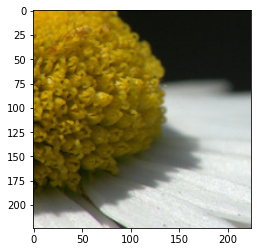

In [26]:
#testing 1 image

def predict_image(img):
    xb = img.unsqueeze(0)
    if gpu_is_available:
        xb=xb.cuda()
    yb = vgg16(xb)
    _,pred = torch.max(yb,dim=1)
    return pred[0].item()


tst_img, tst_label = test_ds[25]
pred = predict_image(tst_img)

print('predicted',pred, 'label', tst_label, 'pred', dataset.classes[pred], 'label:', dataset.classes[tst_label])
plt.imshow(tst_img.permute(1,2,0))



In [22]:
result = evaluate(test_dl)
print(result)

(0.4152842064698537, 0.8466666658719381)


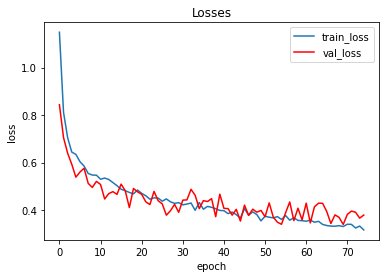

In [23]:
#plot training losses, val losses

plt.plot(out_train_loss, '-')
plt.plot(out_val_loss, '-',color="Red")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.title('Losses');


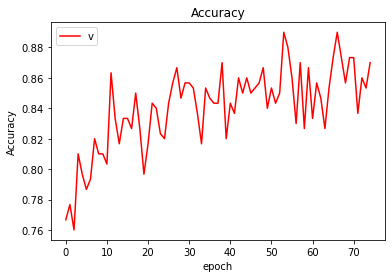

In [24]:
#plot training accuracy

plt.plot(out_val_acc, '-',color="Red")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend('validation_loss')
plt.title('Accuracy');


In [25]:
# jang = torch.tensor([[1,2,3,4,5],[2,3,4,5,6],[3,4,5,6,7]])

# lab = torch.tensor([[3],[4],[4]])

# sum1,maxindx = torch.max(jang,dim=1)

# print(maxindx.shape)
# print(lab.shape)
# print(maxindx == lab)
# print(torch.sum(maxindx == lab))

# # print(jang[0][0].item())

# jang = [1,2,3,4]

# sum(jang)/len(jang)